In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import functions.add_path

import functions.plotnine_theme
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from plotnine import *
from plotnine.data import *

import functions.et_condition_df as condition_df
import functions.et_make_df as  make_df
import be_load

/home/student/b/behinger/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


reached exception:pyaudio
reached exception:optimization_calibration
reached exception:glfw.GLFW_PRESS
reached exception:glfw.GLFW_KEY_SPACE
reached exception:glfw.GLFW_KEY_F
reached exception:glfw.glfwSetKeyCallback
reached exception:fingertip_calibration
reached exception:glfw.GLFW_PRESS
reached exception:natural_features_calibration
reached exception:optimization_calibration
reached exception:optimization_calibration
reached exception:glfw.GLFW_PRESS
reached exception:glfw.GLFW_KEY_SPACE
reached exception:glfw.GLFW_KEY_F
reached exception:glfw.glfwSetKeyCallback
reached exception:fingertip_calibration
reached exception:glfw.GLFW_PRESS
reached exception:natural_features_calibration
reached exception:optimization_calibration


In [3]:
import os
print(os.getcwd())
if os.getcwd()[-4:] != 'code':
    try:
        os.chdir('./code')
    except:
        os.chdir('/net/store/nbp/users/behinger/projects/etcomp/code')


/net/store/nbp/users/behinger/projects/etcomp/lib/pupil/pupil_src/shared_modules/calibration_routines/optimization_calibration


In [4]:
(etsamples,etmsgs,etevents) = be_load.load_data()

loading subject VP1 with et el
loading subject VP1 with et pl
loading subject VP2 with et el
loading subject VP2 with et pl
loading subject VP3 with et el
loading subject VP3 with et pl
loading subject VP4 with et el
loading subject VP4 with et pl
loading subject VP11 with et el
loading subject VP11 with et pl
loading subject VP12 with et el
loading subject VP12 with et pl
loading subject VP14 with et el
loading subject VP14 with et pl
loading subject VP15 with et el
loading subject VP15 with et pl
loading subject VP19 with et el
loading subject VP19 with et pl
loading subject VP20 with et el
loading subject VP20 with et pl
loading subject VP22 with et el
loading subject VP22 with et pl
loading subject VP23 with et el
loading subject VP23 with et pl
loading subject VP24 with et el
loading subject VP24 with et pl
loading subject VP25 with et el
loading subject VP25 with et pl
loading subject VP26 with et el
loading subject VP26 with et pl
loading subject results with et el
File b'/net/s

In [22]:
#%% Do Smooth Pursuit Analysis
smooth = condition_df.get_condition_df(data=(etsamples,etmsgs,etevents),condition="SMOOTHPURSUIT")

[autoreload of SMOOTH failed: Traceback (most recent call last):
  File "/home/student/b/behinger/.local/lib/python3.5/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/student/b/behinger/.local/lib/python3.5/site-packages/IPython/extensions/autoreload.py", line 368, in superreload
    module = reload(module)
  File "/net/store/nbp/users/behinger/projects/etcomp/local/etcompvenv/lib/python3.5/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/net/store/nbp/users/behinger/projects/etcomp/local/etcompvenv/lib/python3.5/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 626, in _exec
  File "<frozen importlib._bootstrap_external>", line 661, in exec_module
  File "<frozen importlib._bootstrap_external>", line 767, in get_code
  File "<frozen importlib._bootstrap_external>", line 727, in source_to_code
  File "<frozen i

In [23]:
smooth_smooth  = smooth.query("type=='smoothpursuit' & condition=='SMOOTH' & exp_event=='trialstart'")
smooth_saccade = smooth.query("type=='saccade'       & condition=='SMOOTH' & exp_event=='trialstart'")

# HMM algorithm init times

In [ ]:
# Smooth Pursuit Init Times
smooth_smooth_first = smooth_smooth.groupby(["subject","block","trial"],as_index=False).first()
smooth_smooth_first.loc[:,'onsettime'] = smooth_smooth_first.start_time-smooth_smooth_first.msg_time

In [ ]:
ggplot(smooth_smooth_first,aes(x="et",y="onsettime",color="et"))+stat_summary()+stat_summary()

At first glance this looks promising. But if we look closer (next plot) we see that its all based on a lie

In [ ]:
select = "subject=='VP2'"

start = smooth_smooth.query(select+"&block==1").msg_time.iloc[0]

dur = 10#s
tmpdata = etsamples.query(select+"&smpl_time>%i & smpl_time <%i"%(start,start+dur))

In [ ]:
(ggplot(tmpdata,aes(x='smpl_time',y='gx',color="type"))+
 geom_point()+
#annotate("vline",aes(xintercept="msg_time"),data=smooth_smooth.query(select+"&block==1&msg_time<=%i"%(start+dur)),)+
 facet_wrap("~eyetracker"))

It became clear that the hmm algorithm is not good enough. The reason is that many fixations are detected as smooith pursuit events

# Piecewise Bayesian Regression
We have to do multiple steps:
- cut the data into epochs
- Rotate the data in the line of the smooth pursuit trajectory (and take only the main direction)
- Fit the Bayesiaan Piecewise Regression model
- Analyse the parameters

In [6]:
def makeRot(theta):
    theta = np.radians(theta)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c,-s), (s, c)))
    return(R)
def rotate(gx,gy,theta):
    R = makeRot(theta).T
    out = np.dot(R,[gx,gy])
    return(out)
def rotateRow(row):
    #print(row[['angle','gx','gy']])
    theta = row.iloc[0].angle
    assert(len(row.angle.unique())==1)
    #print(theta)
    #print(row.gx)
    rot = rotate(row.gx.values,row.gy.values,theta)
    #print(rot[0])
    #print(len(rot[0]))
    #print(row.shape)
    row.loc[:,'rotated'] = rot[0]
    return(row)
    

In [ ]:
rotate(0,1,90)

In [ ]:
epochs = make_df.make_epochs(etsamples.query("eyetracker=='el'&subject=='VP11'"),etmsgs.query("subject=='VP11'&eyetracker=='el'&exp_event=='trialstart'&condition=='SMOOTH'"),td=[-0.1,1])

In [ ]:
rotateRow(epochs.iloc[[0,1,2]])

In [ ]:
epochs=  epochs.groupby("angle",group_keys=False).apply(rotateRow)

In [ ]:
epochs.rotated.unique()

In [ ]:
(ggplot(epochs,aes(x='td',y='rotated',color='vel'))+geom_point())

In [ ]:
epochs.columns

In [ ]:
d = epochs.query("trial==6&block==2&td<0.6")
datafit={'ntime': d.shape[0],
'etdata': d.rotated.values,
'time':d.td.values,
'tauprior':.185}

In [ ]:
plt.plot(datafit['time'],datafit['etdata'])

In [5]:
import SMOOTH

In [ ]:
smoothresult = SMOOTH.fit_bayesian_model(etsamples,etmsgs)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8875299d4f0849455d5b6cf28abae5ce NOW.


msg 0 from 90
msg 50 from 90


/net/store/nbp/users/behinger/projects/etcomp/local/etcompvenv/lib/python3.5/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


no saccade found
no saccade found
no saccade found
Elapsed time: 37.184605 seconds.

msg 0 from 90
msg 50 from 90


ERROR:SMOOTH:Error smooth model fit single trial[]: accessing element out of range. index 0 out of range; expecting index to be between 1 and 0; index position = 1time
Traceback (most recent call last):
  File "/net/store/nbp/users/behinger/projects/etcomp/code/SMOOTH.py", line 70, in fitTrial_pandas
    fit = fitTrial(d,sm)
  File "/net/store/nbp/users/behinger/projects/etcomp/code/SMOOTH.py", line 63, in fitTrial
    fit = sm.sampling(data=datafit, iter=1500,warmup=300, chains=1)
  File "/net/store/nbp/users/behinger/projects/etcomp/local/etcompvenv/lib/python3.5/site-packages/pystan/model.py", line 726, in sampling
    ret_and_samples = _map_parallel(call_sampler_star, call_sampler_args, n_jobs)
  File "/net/store/nbp/users/behinger/projects/etcomp/local/etcompvenv/lib/python3.5/site-packages/pystan/model.py", line 86, in _map_parallel
    map_result = list(map(function, args))
  File "stanfit4anon_model_8875299d4f0849455d5b6cf28abae5ce_6938773370615144799.pyx", line 368, in stanfit

less than 10 samples, aborting
no saccade found
no saccade found
no saccade found
no saccade found
Elapsed time: 21.345924 seconds.

msg 0 from 120
msg 50 from 120
msg 100 from 120
less than 10 samples, aborting


ERROR:SMOOTH:Error smooth model fit single trial[]: accessing element out of range. index 0 out of range; expecting index to be between 1 and 0; index position = 1time
Traceback (most recent call last):
  File "/net/store/nbp/users/behinger/projects/etcomp/code/SMOOTH.py", line 70, in fitTrial_pandas
    fit = fitTrial(d,sm)
  File "/net/store/nbp/users/behinger/projects/etcomp/code/SMOOTH.py", line 63, in fitTrial
    fit = sm.sampling(data=datafit, iter=1500,warmup=300, chains=1)
  File "/net/store/nbp/users/behinger/projects/etcomp/local/etcompvenv/lib/python3.5/site-packages/pystan/model.py", line 726, in sampling
    ret_and_samples = _map_parallel(call_sampler_star, call_sampler_args, n_jobs)
  File "/net/store/nbp/users/behinger/projects/etcomp/local/etcompvenv/lib/python3.5/site-packages/pystan/model.py", line 86, in _map_parallel
    map_result = list(map(function, args))
  File "stanfit4anon_model_8875299d4f0849455d5b6cf28abae5ce_6938773370615144799.pyx", line 368, in stanfit

less than 10 samples, aborting
Elapsed time: 49.379085 seconds.

msg 0 from 120
msg 50 from 120
msg 100 from 120
no saccade found
no saccade found
no saccade found
no saccade found
Elapsed time: 27.980281 seconds.

msg 0 from 120
msg 50 from 120
msg 100 from 120
Elapsed time: 45.458469 seconds.

msg 0 from 120
msg 50 from 120
msg 100 from 120
no saccade found
less than 10 samples, aborting
Elapsed time: 27.911626 seconds.

msg 0 from 120
msg 50 from 120
msg 100 from 120
no saccade found
Elapsed time: 2008.212482 seconds.

msg 0 from 120
msg 50 from 120
msg 100 from 120
no saccade found
no saccade found
no saccade found
Elapsed time: 27.125570 seconds.

msg 0 from 120
msg 50 from 120
msg 100 from 120
no saccade found
no saccade found
no saccade found
no saccade found
no saccade found
no saccade found
no saccade found
Elapsed time: 49.460394 seconds.

msg 0 from 120
msg 50 from 120
msg 100 from 120


ERROR:SMOOTH:Error smooth model fit single trial[]: accessing element out of range. index 0 out of range; expecting index to be between 1 and 0; index position = 1time
Traceback (most recent call last):
  File "/net/store/nbp/users/behinger/projects/etcomp/code/SMOOTH.py", line 70, in fitTrial_pandas
    fit = fitTrial(d,sm)
  File "/net/store/nbp/users/behinger/projects/etcomp/code/SMOOTH.py", line 63, in fitTrial
    fit = sm.sampling(data=datafit, iter=1500,warmup=300, chains=1)
  File "/net/store/nbp/users/behinger/projects/etcomp/local/etcompvenv/lib/python3.5/site-packages/pystan/model.py", line 726, in sampling
    ret_and_samples = _map_parallel(call_sampler_star, call_sampler_args, n_jobs)
  File "/net/store/nbp/users/behinger/projects/etcomp/local/etcompvenv/lib/python3.5/site-packages/pystan/model.py", line 86, in _map_parallel
    map_result = list(map(function, args))
  File "stanfit4anon_model_8875299d4f0849455d5b6cf28abae5ce_6938773370615144799.pyx", line 368, in stanfit

less than 10 samples, aborting
no saccade found


ERROR:SMOOTH:Error smooth model fit single trial[]: accessing element out of range. index 0 out of range; expecting index to be between 1 and 0; index position = 1time
Traceback (most recent call last):
  File "/net/store/nbp/users/behinger/projects/etcomp/code/SMOOTH.py", line 70, in fitTrial_pandas
    fit = fitTrial(d,sm)
  File "/net/store/nbp/users/behinger/projects/etcomp/code/SMOOTH.py", line 63, in fitTrial
    fit = sm.sampling(data=datafit, iter=1500,warmup=300, chains=1)
  File "/net/store/nbp/users/behinger/projects/etcomp/local/etcompvenv/lib/python3.5/site-packages/pystan/model.py", line 726, in sampling
    ret_and_samples = _map_parallel(call_sampler_star, call_sampler_args, n_jobs)
  File "/net/store/nbp/users/behinger/projects/etcomp/local/etcompvenv/lib/python3.5/site-packages/pystan/model.py", line 86, in _map_parallel
    map_result = list(map(function, args))
  File "stanfit4anon_model_8875299d4f0849455d5b6cf28abae5ce_6938773370615144799.pyx", line 368, in stanfit

less than 10 samples, aborting
no saccade found


ERROR:SMOOTH:Error smooth model fit single trial[]: accessing element out of range. index 0 out of range; expecting index to be between 1 and 0; index position = 1time
Traceback (most recent call last):
  File "/net/store/nbp/users/behinger/projects/etcomp/code/SMOOTH.py", line 70, in fitTrial_pandas
    fit = fitTrial(d,sm)
  File "/net/store/nbp/users/behinger/projects/etcomp/code/SMOOTH.py", line 63, in fitTrial
    fit = sm.sampling(data=datafit, iter=1500,warmup=300, chains=1)
  File "/net/store/nbp/users/behinger/projects/etcomp/local/etcompvenv/lib/python3.5/site-packages/pystan/model.py", line 726, in sampling
    ret_and_samples = _map_parallel(call_sampler_star, call_sampler_args, n_jobs)
  File "/net/store/nbp/users/behinger/projects/etcomp/local/etcompvenv/lib/python3.5/site-packages/pystan/model.py", line 86, in _map_parallel
    map_result = list(map(function, args))
  File "stanfit4anon_model_8875299d4f0849455d5b6cf28abae5ce_6938773370615144799.pyx", line 368, in stanfit

less than 10 samples, aborting
Elapsed time: 22.216885 seconds.

msg 0 from 120
msg 50 from 120
msg 100 from 120
no saccade found
no saccade found
Elapsed time: 48.856758 seconds.

msg 0 from 120
msg 50 from 120
msg 100 from 120
Elapsed time: 26.989286 seconds.

msg 0 from 120
msg 50 from 120
msg 100 from 120
no saccade found
Elapsed time: 41.625144 seconds.

msg 0 from 120
msg 50 from 120
msg 100 from 120
less than 10 samples, aborting
Elapsed time: 24.417125 seconds.

msg 0 from 120
msg 50 from 120
msg 100 from 120
no saccade found
Elapsed time: 46.171760 seconds.

msg 0 from 120
msg 50 from 120
msg 100 from 120
no saccade found
no saccade found
Elapsed time: 28.599170 seconds.

msg 0 from 120
msg 50 from 120
msg 100 from 120
no saccade found
Elapsed time: 43.280263 seconds.

msg 0 from 120
msg 50 from 120
msg 100 from 120


ERROR:SMOOTH:Error smooth model fit single trial[]: accessing element out of range. index 0 out of range; expecting index to be between 1 and 0; index position = 1time
Traceback (most recent call last):
  File "/net/store/nbp/users/behinger/projects/etcomp/code/SMOOTH.py", line 70, in fitTrial_pandas
    fit = fitTrial(d,sm)
  File "/net/store/nbp/users/behinger/projects/etcomp/code/SMOOTH.py", line 63, in fitTrial
    fit = sm.sampling(data=datafit, iter=1500,warmup=300, chains=1)
  File "/net/store/nbp/users/behinger/projects/etcomp/local/etcompvenv/lib/python3.5/site-packages/pystan/model.py", line 726, in sampling
    ret_and_samples = _map_parallel(call_sampler_star, call_sampler_args, n_jobs)
  File "/net/store/nbp/users/behinger/projects/etcomp/local/etcompvenv/lib/python3.5/site-packages/pystan/model.py", line 86, in _map_parallel
    map_result = list(map(function, args))
  File "stanfit4anon_model_8875299d4f0849455d5b6cf28abae5ce_6938773370615144799.pyx", line 368, in stanfit

less than 10 samples, aborting
no saccade found
Elapsed time: 25.381278 seconds.

msg 0 from 120
msg 50 from 120
msg 100 from 120
Elapsed time: 44.538971 seconds.

msg 0 from 120
msg 50 from 120


block                  6
condition         SMOOTH
element              NaN
exp_event     trialstart
grid_size            NaN
lum                  NaN
msg_time         3553.97
pic_id               NaN
posx                 NaN
posy                 NaN
shake_x              NaN
shake_y              NaN
trial                  2
vel                   24
algorithm            hmm
eyetracker            pl
subject             VP20
beep                 NaN
Name: 48736, dtype: object
block                  6
condition         SMOOTH
element              NaN
exp_event     trialstart
grid_size            NaN
lum                  NaN
msg_time         3556.61
pic_id               NaN
posx                 NaN
posy                 NaN
shake_x              NaN
shake_y              NaN
trial                  3
vel                   24
algorithm            hmm
eyetracker            pl
subject             VP20
beep                 NaN
Name: 48738, dtype: object


msg 100 from 120
no saccade found
Elapsed time: 26.546977 seconds.

msg 0 from 120
msg 50 from 120
msg 100 from 120
Elapsed time: 25.339264 seconds.

msg 0 from 120


block                  4
condition         SMOOTH
element              NaN
exp_event     trialstart
grid_size            NaN
lum                  NaN
msg_time          3153.9
pic_id               NaN
posx                 NaN
posy                 NaN
shake_x              NaN
shake_y              NaN
trial                  2
vel                   22
algorithm            hmm
eyetracker            pl
subject             VP22
beep                 NaN
Name: 53291, dtype: object
block                  4
condition         SMOOTH
element              NaN
exp_event     trialstart
grid_size            NaN
lum                  NaN
msg_time         3158.35
pic_id               NaN
posx                 NaN
posy                 NaN
shake_x              NaN
shake_y              NaN
trial                  3
vel                   24
algorithm            hmm
eyetracker            pl
subject             VP22
beep                 NaN
Name: 53293, dtype: object


msg 50 from 120
msg 100 from 120


ERROR:SMOOTH:Error smooth model fit single trial[]: accessing element out of range. index 0 out of range; expecting index to be between 1 and 0; index position = 1time
Traceback (most recent call last):
  File "/net/store/nbp/users/behinger/projects/etcomp/code/SMOOTH.py", line 70, in fitTrial_pandas
    fit = fitTrial(d,sm)
  File "/net/store/nbp/users/behinger/projects/etcomp/code/SMOOTH.py", line 63, in fitTrial
    fit = sm.sampling(data=datafit, iter=1500,warmup=300, chains=1)
  File "/net/store/nbp/users/behinger/projects/etcomp/local/etcompvenv/lib/python3.5/site-packages/pystan/model.py", line 726, in sampling
    ret_and_samples = _map_parallel(call_sampler_star, call_sampler_args, n_jobs)
  File "/net/store/nbp/users/behinger/projects/etcomp/local/etcompvenv/lib/python3.5/site-packages/pystan/model.py", line 86, in _map_parallel
    map_result = list(map(function, args))
  File "stanfit4anon_model_8875299d4f0849455d5b6cf28abae5ce_6938773370615144799.pyx", line 368, in stanfit

less than 10 samples, aborting
no saccade found
Elapsed time: 23.137514 seconds.

msg 0 from 120
msg 50 from 120
msg 100 from 120
no saccade found
Elapsed time: 25.297284 seconds.



block                  2
condition         SMOOTH
element              NaN
exp_event     trialstart
grid_size            NaN
lum                  NaN
msg_time         815.334
pic_id               NaN
posx                 NaN
posy                 NaN
shake_x              NaN
shake_y              NaN
trial                  1
vel                   20
algorithm            hmm
eyetracker            pl
subject             VP23
beep                 NaN
Name: 57315, dtype: object
block                  2
condition         SMOOTH
element              NaN
exp_event     trialstart
grid_size            NaN
lum                  NaN
msg_time         819.016
pic_id               NaN
posx                 NaN
posy                 NaN
shake_x              NaN
shake_y              NaN
trial                  2
vel                   20
algorithm            hmm
eyetracker            pl
subject             VP23
beep                 NaN
Name: 57317, dtype: object
block                  2
condition         SMO

msg 0 from 120


block                  2
condition         SMOOTH
element              NaN
exp_event     trialstart
grid_size            NaN
lum                  NaN
msg_time         862.693
pic_id               NaN
posx                 NaN
posy                 NaN
shake_x              NaN
shake_y              NaN
trial                 19
vel                   20
algorithm            hmm
eyetracker            pl
subject             VP23
beep                 NaN
Name: 57351, dtype: object
block                  2
condition         SMOOTH
element              NaN
exp_event     trialstart
grid_size            NaN
lum                  NaN
msg_time          867.82
pic_id               NaN
posx                 NaN
posy                 NaN
shake_x              NaN
shake_y              NaN
trial                 20
vel                   22
algorithm            hmm
eyetracker            pl
subject             VP23
beep                 NaN
Name: 57353, dtype: object


msg 50 from 120
msg 100 from 120


ERROR:SMOOTH:Error smooth model fit single trial[]: accessing element out of range. index 0 out of range; expecting index to be between 1 and 0; index position = 1time
Traceback (most recent call last):
  File "/net/store/nbp/users/behinger/projects/etcomp/code/SMOOTH.py", line 70, in fitTrial_pandas
    fit = fitTrial(d,sm)
  File "/net/store/nbp/users/behinger/projects/etcomp/code/SMOOTH.py", line 63, in fitTrial
    fit = sm.sampling(data=datafit, iter=1500,warmup=300, chains=1)
  File "/net/store/nbp/users/behinger/projects/etcomp/local/etcompvenv/lib/python3.5/site-packages/pystan/model.py", line 726, in sampling
    ret_and_samples = _map_parallel(call_sampler_star, call_sampler_args, n_jobs)
  File "/net/store/nbp/users/behinger/projects/etcomp/local/etcompvenv/lib/python3.5/site-packages/pystan/model.py", line 86, in _map_parallel
    map_result = list(map(function, args))
  File "stanfit4anon_model_8875299d4f0849455d5b6cf28abae5ce_6938773370615144799.pyx", line 368, in stanfit

less than 10 samples, aborting


ERROR:SMOOTH:Error smooth model fit single trial[]: accessing element out of range. index 0 out of range; expecting index to be between 1 and 0; index position = 1time
Traceback (most recent call last):
  File "/net/store/nbp/users/behinger/projects/etcomp/code/SMOOTH.py", line 70, in fitTrial_pandas
    fit = fitTrial(d,sm)
  File "/net/store/nbp/users/behinger/projects/etcomp/code/SMOOTH.py", line 63, in fitTrial
    fit = sm.sampling(data=datafit, iter=1500,warmup=300, chains=1)
  File "/net/store/nbp/users/behinger/projects/etcomp/local/etcompvenv/lib/python3.5/site-packages/pystan/model.py", line 726, in sampling
    ret_and_samples = _map_parallel(call_sampler_star, call_sampler_args, n_jobs)
  File "/net/store/nbp/users/behinger/projects/etcomp/local/etcompvenv/lib/python3.5/site-packages/pystan/model.py", line 86, in _map_parallel
    map_result = list(map(function, args))
  File "stanfit4anon_model_8875299d4f0849455d5b6cf28abae5ce_6938773370615144799.pyx", line 368, in stanfit

less than 10 samples, aborting


ERROR:SMOOTH:Error smooth model fit single trial[]: accessing element out of range. index 0 out of range; expecting index to be between 1 and 0; index position = 1time
Traceback (most recent call last):
  File "/net/store/nbp/users/behinger/projects/etcomp/code/SMOOTH.py", line 70, in fitTrial_pandas
    fit = fitTrial(d,sm)
  File "/net/store/nbp/users/behinger/projects/etcomp/code/SMOOTH.py", line 63, in fitTrial
    fit = sm.sampling(data=datafit, iter=1500,warmup=300, chains=1)
  File "/net/store/nbp/users/behinger/projects/etcomp/local/etcompvenv/lib/python3.5/site-packages/pystan/model.py", line 726, in sampling
    ret_and_samples = _map_parallel(call_sampler_star, call_sampler_args, n_jobs)
  File "/net/store/nbp/users/behinger/projects/etcomp/local/etcompvenv/lib/python3.5/site-packages/pystan/model.py", line 86, in _map_parallel
    map_result = list(map(function, args))
  File "stanfit4anon_model_8875299d4f0849455d5b6cf28abae5ce_6938773370615144799.pyx", line 368, in stanfit

less than 10 samples, aborting


ERROR:SMOOTH:Error smooth model fit single trial[]: accessing element out of range. index 0 out of range; expecting index to be between 1 and 0; index position = 1time
Traceback (most recent call last):
  File "/net/store/nbp/users/behinger/projects/etcomp/code/SMOOTH.py", line 70, in fitTrial_pandas
    fit = fitTrial(d,sm)
  File "/net/store/nbp/users/behinger/projects/etcomp/code/SMOOTH.py", line 63, in fitTrial
    fit = sm.sampling(data=datafit, iter=1500,warmup=300, chains=1)
  File "/net/store/nbp/users/behinger/projects/etcomp/local/etcompvenv/lib/python3.5/site-packages/pystan/model.py", line 726, in sampling
    ret_and_samples = _map_parallel(call_sampler_star, call_sampler_args, n_jobs)
  File "/net/store/nbp/users/behinger/projects/etcomp/local/etcompvenv/lib/python3.5/site-packages/pystan/model.py", line 86, in _map_parallel
    map_result = list(map(function, args))
  File "stanfit4anon_model_8875299d4f0849455d5b6cf28abae5ce_6938773370615144799.pyx", line 368, in stanfit

less than 10 samples, aborting
less than 10 samples, aborting


ERROR:SMOOTH:Error smooth model fit single trial[]: accessing element out of range. index 0 out of range; expecting index to be between 1 and 0; index position = 1time
Traceback (most recent call last):
  File "/net/store/nbp/users/behinger/projects/etcomp/code/SMOOTH.py", line 70, in fitTrial_pandas
    fit = fitTrial(d,sm)
  File "/net/store/nbp/users/behinger/projects/etcomp/code/SMOOTH.py", line 63, in fitTrial
    fit = sm.sampling(data=datafit, iter=1500,warmup=300, chains=1)
  File "/net/store/nbp/users/behinger/projects/etcomp/local/etcompvenv/lib/python3.5/site-packages/pystan/model.py", line 726, in sampling
    ret_and_samples = _map_parallel(call_sampler_star, call_sampler_args, n_jobs)
  File "/net/store/nbp/users/behinger/projects/etcomp/local/etcompvenv/lib/python3.5/site-packages/pystan/model.py", line 86, in _map_parallel
    map_result = list(map(function, args))
  File "stanfit4anon_model_8875299d4f0849455d5b6cf28abae5ce_6938773370615144799.pyx", line 368, in stanfit

less than 10 samples, aborting


ERROR:SMOOTH:Error smooth model fit single trial[]: accessing element out of range. index 0 out of range; expecting index to be between 1 and 0; index position = 1time
Traceback (most recent call last):
  File "/net/store/nbp/users/behinger/projects/etcomp/code/SMOOTH.py", line 70, in fitTrial_pandas
    fit = fitTrial(d,sm)
  File "/net/store/nbp/users/behinger/projects/etcomp/code/SMOOTH.py", line 63, in fitTrial
    fit = sm.sampling(data=datafit, iter=1500,warmup=300, chains=1)
  File "/net/store/nbp/users/behinger/projects/etcomp/local/etcompvenv/lib/python3.5/site-packages/pystan/model.py", line 726, in sampling
    ret_and_samples = _map_parallel(call_sampler_star, call_sampler_args, n_jobs)
  File "/net/store/nbp/users/behinger/projects/etcomp/local/etcompvenv/lib/python3.5/site-packages/pystan/model.py", line 86, in _map_parallel
    map_result = list(map(function, args))
  File "stanfit4anon_model_8875299d4f0849455d5b6cf28abae5ce_6938773370615144799.pyx", line 368, in stanfit

less than 10 samples, aborting
no saccade found
less than 10 samples, aborting
Elapsed time: 21.793517 seconds.

msg 0 from 120
msg 50 from 120
msg 100 from 120
no saccade found
Elapsed time: 23.094277 seconds.

msg 0 from 120
msg 50 from 120
msg 100 from 120


ERROR:SMOOTH:Error smooth model fit single trial[]: accessing element out of range. index 0 out of range; expecting index to be between 1 and 0; index position = 1time
Traceback (most recent call last):
  File "/net/store/nbp/users/behinger/projects/etcomp/code/SMOOTH.py", line 70, in fitTrial_pandas
    fit = fitTrial(d,sm)
  File "/net/store/nbp/users/behinger/projects/etcomp/code/SMOOTH.py", line 63, in fitTrial
    fit = sm.sampling(data=datafit, iter=1500,warmup=300, chains=1)
  File "/net/store/nbp/users/behinger/projects/etcomp/local/etcompvenv/lib/python3.5/site-packages/pystan/model.py", line 726, in sampling
    ret_and_samples = _map_parallel(call_sampler_star, call_sampler_args, n_jobs)
  File "/net/store/nbp/users/behinger/projects/etcomp/local/etcompvenv/lib/python3.5/site-packages/pystan/model.py", line 86, in _map_parallel
    map_result = list(map(function, args))
  File "stanfit4anon_model_8875299d4f0849455d5b6cf28abae5ce_6938773370615144799.pyx", line 368, in stanfit

less than 10 samples, aborting
Elapsed time: 22.120451 seconds.

msg 0 from 120
msg 50 from 120
msg 100 from 120
no saccade found
Elapsed time: 23.599081 seconds.

msg 0 from 120
msg 50 from 120
msg 100 from 120


In [56]:
SMOOTH.save_smooth(smoothresult)

saving...
... saving done


In [8]:
smoothresult

,trial,block,summary,taumean,taustd,eyetracker,subject
0,1.0,1.0,"{'c_summary_colnames': ('mean', 'sd', '2.5%', ...",0.345875,0.002255,el,VP1
1,1.0,2.0,"{'c_summary_colnames': ('mean', 'sd', '2.5%', ...",0.243425,0.002647,el,VP1
2,1.0,3.0,"{'c_summary_colnames': ('mean', 'sd', '2.5%', ...",0.150728,0.004899,el,VP1
3,1.0,4.0,"{'c_summary_colnames': ('mean', 'sd', '2.5%', ...",0.346904,0.003038,el,VP1
4,1.0,5.0,"{'c_summary_colnames': ('mean', 'sd', '2.5%', ...",0.267149,0.003189,el,VP1
5,1.0,6.0,"{'c_summary_colnames': ('mean', 'sd', '2.5%', ...",0.066201,0.026463,el,VP1
6,2.0,1.0,"{'c_summary_colnames': ('mean', 'sd', '2.5%', ...",0.214582,0.004210,el,VP1
7,2.0,2.0,"{'c_summary_colnames': ('mean', 'sd', '2.5%', ...",0.195681,0.006606,el,VP1
8,2.0,3.0,"{'c_summary_colnames': ('mean', 'sd', '2.5%', ...",0.317892,0.003132,el,VP1
9,2.0,4.0,"{'c_summary_colnames': ('mean', 'sd', '2.5%', ...",0.227310,0.004495,el,VP1


In [16]:
min(smoothresult['taumean'])

0.002542686643347097

/net/store/nbp/users/behinger/projects/etcomp/local/etcompvenv/lib/python3.5/site-packages/plotnine/layer.py:363: UserWarning: stat_summary : Removed 15 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
/net/store/nbp/users/behinger/projects/etcomp/local/etcompvenv/lib/python3.5/site-packages/plotnine/layer.py:452: UserWarning: geom_point : Removed 15 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


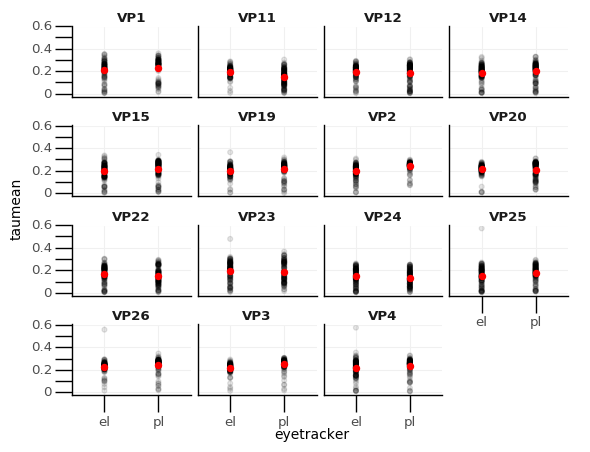

<ggplot: (8781545672175)>

In [28]:
ggplot(smoothresult,aes(x="eyetracker",y="taumean"))+geom_point(alpha=0.1)+stat_summary(color='red')+facet_wrap("~subject")

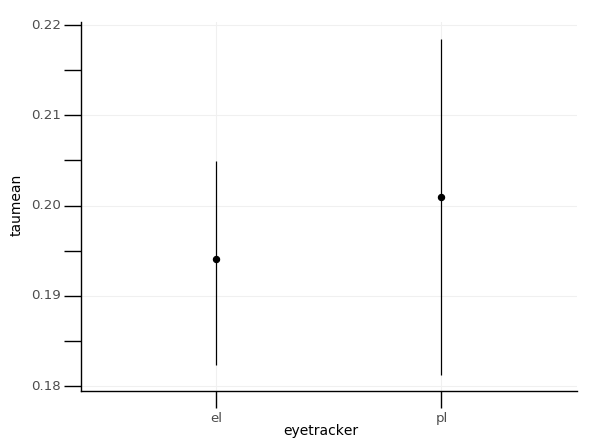

<ggplot: (-9223363255334889861)>

In [31]:
smoothgroup = smoothresult.groupby(['eyetracker','subject'],as_index=False).apply(np.mean).reset_index()
ggplot(smoothgroup,aes(x="eyetracker",y="taumean"))+stat_summary()

In [21]:
smoothresult = SMOOTH.load_smooth()

In [33]:
smoothgroup = smoothresult.groupby(['eyetracker','subject'],as_index=False).apply(np.mean).reset_index()

In [37]:
smoothgroup

,eyetracker,subject,trial,block,taumean,taustd
0,el,VP1,8.000000,3.500000,0.207544,0.007280
1,el,VP11,10.500000,3.500000,0.195817,0.003195
2,el,VP12,10.500000,3.500000,0.194713,0.004056
3,el,VP14,10.500000,3.500000,0.187805,0.005400
4,el,VP15,10.500000,3.500000,0.194494,0.006307
5,el,VP19,10.500000,3.500000,0.200461,0.002905
6,el,VP2,10.500000,3.500000,0.192980,0.006381
7,el,VP20,10.500000,3.500000,0.210978,0.003097
8,el,VP22,10.500000,3.500000,0.170496,0.009502
9,el,VP23,10.500000,3.500000,0.195701,0.012805


In [52]:
d = smoothgroup.groupby("subject").agg({'taumean':{'taudiff':np.diff}})
ggplot(d,aes(x="taumean"))+geom_histogram()

In [11]:
sm =SMOOTH.compileModel('changepoint.stan')
#sm2 =SMOOTH.compileModel('changepoint2.stan')

msg 0 from 1


/net/store/nbp/users/behinger/projects/etcomp/local/etcompvenv/lib/python3.5/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/net/store/nbp/users/behinger/projects/etcomp/local/etcompvenv/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


msg 0 from 1


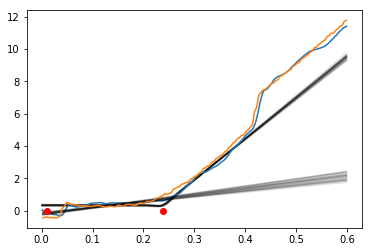

In [16]:
subject = 'VP3'
block = 1
fit = dict()
fit['el'] = plot_single_trial(subject,'el',10,block,sm)
fit['pl'] = plot_single_trial(subject,'pl',10,block,sm)

In [269]:
fit['pl']

Inference for Stan model: anon_model_8875299d4f0849455d5b6cf28abae5ce.
1 chains, each with iter=1500; warmup=300; thin=1; 
post-warmup draws per chain=1200, total post-warmup draws=1200.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma    0.14  4.7e-4   0.01   0.11   0.13   0.14   0.15   0.17    922    1.0
slope    4.08    0.03   0.75   2.77   3.53   4.02   4.53   5.66    722    1.0
offset  -0.11  8.2e-4   0.02  -0.16  -0.12  -0.11  -0.09  -0.06    821    1.0
tau      0.12  4.0e-4   0.01    0.1   0.12   0.12   0.13   0.15    726    1.0
lp__    79.14    0.07   1.52  75.44  78.28  79.48  80.27  81.14    467    1.0

Samples were drawn using NUTS at Fri Aug  3 13:58:27 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [ ]:
#%% Do Smooth Pursuit Analysis
smooth = condition_df.get_condition_df(data=(etsamples,etmsgs,etevents),condition="SMOOTHPURSUIT")

In [ ]:
smooth_saccade_agg = smooth_saccade.groupby(["subject","et","block","trial","angle","vel"],as_index=False).agg({'amplitude':np.mean})
ggplot(smooth_saccade_agg,aes(x="vel",y="amplitude",color="et"))+stat_summary()+ylab('Number of Catchup Saccades')

In [ ]:
smooth_smooth  = smooth.query("type=='smoothpursuit' & condition=='SMOOTH' & exp_event=='trialstart'")
smooth_saccade = smooth.query("type=='saccade'       & condition=='SMOOTH' & exp_event=='trialstart'")

In [ ]:
ggplot(smooth_saccade_agg,aes(x="amplitude",group="subject"))+geom_density()+facet_grid("et~.")

In [ ]:
# Smooth Pursuit Init Times
smooth_smooth_first = smooth_smooth.groupby(["subject","block","trial"],as_index=False).first()
smooth_smooth_first.loc[:,'onsettime'] = smooth_smooth_first.start_time-smooth_smooth_first.msg_time

In [ ]:
ggplot(smooth_smooth_first,aes(x="et",y="onsettime",color="et"))+stat_summary()

In [ ]:
smooth_saccade_agg = smooth_saccade.groupby(["subject","et","block","trial","angle","vel"],as_index=False).agg({'amplitude':np.mean})
ggplot(smooth_saccade_agg,aes(x="vel",y="amplitude",color="et"))+stat_summary()+ylab('Number of Catchup Saccades')

In [ ]:
select = "subject=='VP2'"

start = smooth_smooth.query(select+"&block==1").msg_time.iloc[0]

In [ ]:
ggplot(smooth_smooth_first,aes(x="et",y="onsettime",color="et"))+geom_point()+facet_wrap("~subject")